- 모든 rotation을 특정해서 미리 key를 만들어두면 한방에 rotation 가능. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt 
#from fase.core import heaan

import fase
#fase.USE_CUDA = True
#from fase import HEAAN
#from fase import HEAAN as he
from fase.core import heaan
#he = heaan.he
from typing import List, Callable
#from fase.core.heaan import HEAANContext 
#from fase.HEAAN import Ciphertext

import fase.nn.utils as utils

Using CPU version HEAAN


## 새로운 키를 생성하려니 작동 불가...??

In [3]:
hec = heaan.HEAANContext(10, 30, 450, boot=True, load_sk=True, rot_l="all")

Initializing the scheme as the data owner
Loading a secret key from:  ./SecretKey.txt
loading secret key done.
loading boot keys done
HEAAN CKKS setup is ready 


In [4]:
hec._lkey

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

Convenience functions

In [5]:
def myprint(*x):
    print(*x, flush=True)

def decrypt_print(ctx, n=20):
    res1 = decrypt(secretKey, ctx)
    print(res1[:n])
    
def decrypt(secretKey, enc):
    featurized = scheme.decrypt(secretKey, enc)
    arr = np.zeros(n, dtype=np.complex128)
    featurized.__getarr__(arr)
    return arr.real

def encrypt(val):
    ctxt = he.Ciphertext()#logp, logq, n)
    vv = np.zeros(n) # Need to initialize to zero or will cause "unbound"
    vv[:len(val)] = val
    scheme.encrypt(ctxt, he.Double(vv), n, logp, logq)
    del vv
    return ctxt

## Torch model

In [6]:
from time import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
import torch

from fase.nn. torch_cnn import *

In [7]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

device = "cpu"

train_loader, valid_loader, test_loader = get_data_loaders()

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


## Load trained model

In [8]:
from fase.nn.models import ConvNeuralNet
from fase.nn.approximate import approx_relu, approx_sign

xfactor = 20
activation = lambda x : xfactor * approx_relu(x/xfactor, degree = 5, repeat=3)


# F.relu or activation?
org_model = ConvNeuralNet(num_classes=10, activation=F.relu) 

In [9]:
fn_param = "SimpleCNN_ReLU_minimax_v2.pt"

trained_param = torch.load(fn_param, map_location=torch.device(device))
trained_param = {k: v.cpu() for k, v in trained_param.items()} # to cpu()
org_model.load_state_dict(trained_param)
org_model.eval() ## If not eval(), running_mean and running_var of batch_norm changes

# To numpy
params_np = {k: v.numpy() for k, v in trained_param.items()}

# HEAAN FHE

In [10]:
import torchvision.transforms as transforms

img = np.array(Image.open("./bird6.png"))
to_tensor = transforms.ToTensor() # [n_channel, nh, nw]
img_tensor = to_tensor(img).unsqueeze(0) # [n_batch, n_channel, nh, nw]
n_batch, n_channel, nh, nw = img_tensor.shape

print(img_tensor.shape)

img_this_example = img_tensor[0] # Assume batch size = 1
img_enc = [hec.encrypt(this_channel.ravel()) for this_channel in img_this_example]

hec.decrypt(img_enc[0])

torch.Size([1, 3, 32, 32])


array([0.65097913, 0.63137222, 0.61176452, ..., 0.76470518, 0.75686353,
       0.73333461])

In [11]:
util = utils.Heaan_checker(hec)

In [17]:
from fase.nn.conv import get_out_size, gen_pad_mask
from fase.nn.conv_he import convolve_fhe, fhe_avg_pool, fhe_bn

In [19]:
org_tt3 = org_model.pool(img_tensor)

tmp3, nh2, nw2 = fhe_avg_pool(hec, img_enc,
                                nh, nw, 
                                kernel_size=org_model.pool.kernel_size, 
                                stride_in=1) # list of ctxts

Output image size 16 16
11 out_fhe.logp, logq 60 450
11 out_fhe.logp, logq 60 450
11 out_fhe.logp, logq 60 450


In [20]:
util.check_ctxt(tmp3[0])

logp 30 logq 390


average diff -0.000 sigma


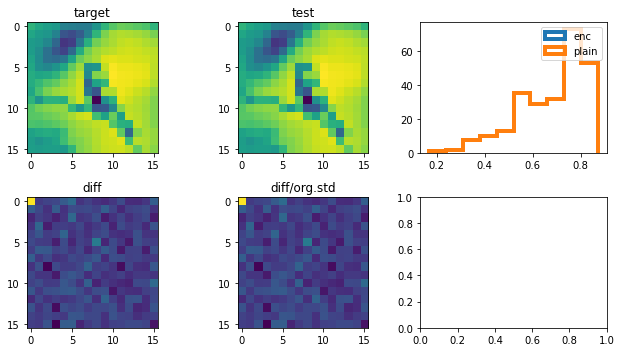

logp 30 logq 390


In [21]:
util.plot_diff(org_tt3, tmp3, 32,32, ch=0, unpad=0, stride=(2,2))
util.check_ctxt(tmp3[0])

In [10]:
from fase.core.commonAlgo import CommonAlgorithms

from conv_he import *

In [11]:
calgo = CommonAlgorithms(hec, "HEAAN")
ff = approx_sign(5)

In [24]:
org_tt5 = org_model.activation(org_tt3)

In [25]:
tmp5 = approx_relu_fhe(hec, calgo, tmp3, ff, repeat=4, xfactor=20)

Bootstrapped 0 2
Bootstrapped 1 2
Bootstrapped 2 2


average diff 0.074 sigma


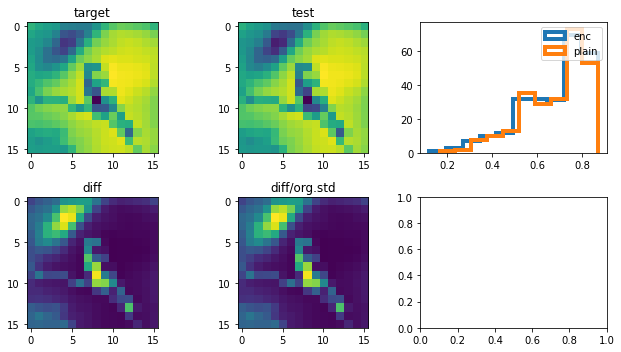

logp 30 logq 90


In [26]:
util.plot_diff(org_tt5, tmp5, 32,32, ch=0, unpad=0, stride=(2,2))
util.check_ctxt(tmp5[0])

Output image size 8 8
11 out_fhe.logp, logq 60 90
11 out_fhe.logp, logq 60 90
11 out_fhe.logp, logq 60 90
average diff 0.085 sigma


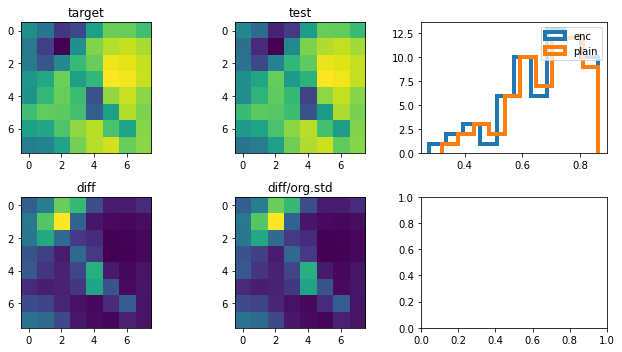

logp 30 logq 30


In [27]:
org_tt8 = org_model.pool(org_tt5)

tmp8, nh2, nw2 = fhe_avg_pool(hec, tmp5,
                                nh, nw, 
                                kernel_size=org_model.pool.kernel_size, 
                                stride_in=2) # list of ctxts

util.plot_diff(org_tt8, tmp8, 32,32, ch=0, unpad=0, stride=(4,4))
util.check_ctxt(tmp8[0])

In [29]:
def do_bootstrap(fhec, ctxt):
    ctxt = fhec.decrypt(ctxt)
    return fhec.encrypt(ctxt)

tmp8_ = [do_bootstrap(hec, tt) for tt in tmp8]

average diff 0.085 sigma


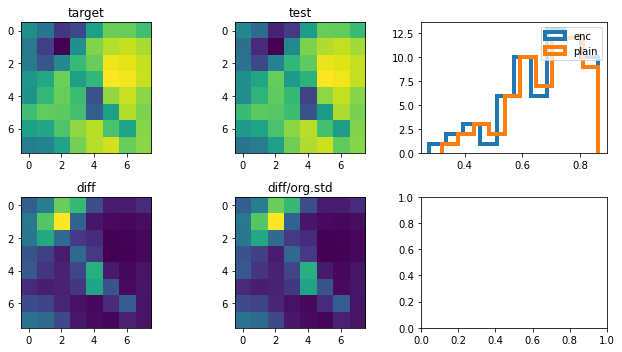

logp 30 logq 450


In [31]:
util.plot_diff(org_tt8, tmp8_, 32,32, ch=0, unpad=0, stride=(4,4))
util.check_ctxt(tmp8_[0])

Output image size 4 4
11 out_fhe.logp, logq 60 450
11 out_fhe.logp, logq 60 450
11 out_fhe.logp, logq 60 450
average diff 0.099 sigma


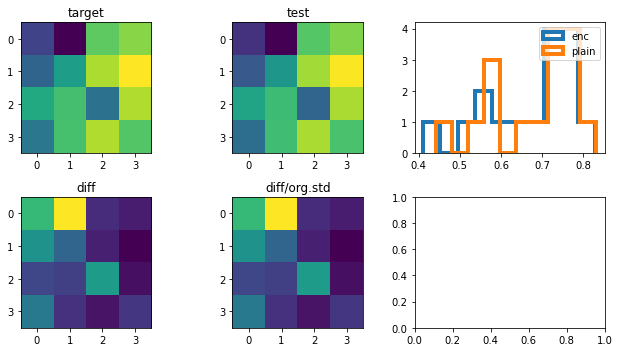

logp 30 logq 390


In [32]:
org_tt10 = org_model.pool(org_tt8)

tmp10, nh2, nw2 = fhe_avg_pool(hec, tmp8_,
                                nh, nw, 
                                kernel_size=org_model.pool.kernel_size, 
                                stride_in=4) # list of ctxts

util.plot_diff(org_tt10, tmp10, 32,32, ch=0, unpad=0, stride=(8,8))
util.check_ctxt(tmp10[0])

# reshape

In [ ]:
hec.rescale

In [ ]:
org_tt10_ = org_tt10.reshape(org_tt10.size(0),-1)



In [51]:
reshaped = reshape(hec, tmp10)

org_tt10_ = org_tt10.reshape(org_tt10.size(0),-1)

[ 4.99551324e-01  3.56749894e-08 -2.31858526e-08 ... -7.13272596e-08
  3.79198638e-08 -9.63490893e-08]
30 360
[ 4.99551324e-01  3.56749894e-08 -2.31858526e-08 ... -7.13272596e-08
  3.79198638e-08 -9.63490893e-08]
30 360
[ 9.99102648e-01  7.13499789e-08 -4.63717052e-08 ... -1.42654519e-07
  7.58397275e-08 -1.92698179e-07]
30 360
[ 1.37589559e-08 -3.00618933e-08 -3.77299672e-08 ... -7.58162536e-09
 -1.93378857e-08  8.76134132e-08]
30 360
[ 9.99102671e-01  4.11515622e-01 -1.18551954e-07 ... -2.32883143e-07
 -5.07187982e-08 -3.23308571e-07]
30 360
[-3.03896702e-08 -1.88303085e-08 -2.59058386e-08 ...  1.11639720e-08
 -1.05158685e-07 -5.53802392e-08]
30 360
[ 9.99102816e-01  4.11515569e-01  7.28205972e-01 ... -3.94505217e-07
 -8.32660652e-08 -2.73485544e-07]
30 360
[-4.57587757e-08 -3.35933334e-08  8.72694572e-08 ...  2.51367483e-08
 -3.66470787e-08 -3.38885729e-08]
30 360
[ 9.99102912e-01  4.11515518e-01  7.28205977e-01 ... -6.82795211e-07
 -1.22297143e-07 -4.73188407e-07]
30 360
[-1.150507

[ 7.75722152e-09  3.70851572e-08  1.89692172e-08 ...  7.11606981e-08
  1.51213027e-08 -1.76289519e-09]
30 360
[9.99104487e-01 4.11515411e-01 7.28203803e-01 ... 1.94481992e-08
 9.31440339e-01 6.71224446e-01]
30 360
[ 1.76617005e-07 -3.94695805e-08  3.70543482e-08 ...  7.92576121e-08
  3.38809592e-09 -4.05417511e-08]
30 360
[ 9.99104738e-01  4.11515512e-01  7.28203464e-01 ... -7.95996932e-08
  9.31440347e-01  6.71224196e-01]
30 360
[3.46606249e-08 1.48415014e-07 1.20937442e-08 ... 1.23066090e-07
 5.49117315e-08 8.66175313e-08]
30 360
[ 9.99104601e-01  4.11515491e-01  7.28203781e-01 ... -7.25476127e-08
  9.31440193e-01  6.71224407e-01]
30 360
[ 7.03016886e-08  1.97882585e-07  6.50679730e-08 ... -1.48176773e-07
 -5.19742234e-08 -1.23378604e-07]
30 360
[ 9.99104610e-01  4.11515247e-01  7.28203912e-01 ... -5.28373346e-08
  9.31440374e-01  6.71224294e-01]
30 360
[-3.04948474e-08 -2.89471686e-08  5.19842588e-08 ...  5.12368684e-09
 -4.21201580e-08 -8.68073297e-08]
30 360
[ 9.99104524e-01  4.11

여기서부터 다시..

In [14]:
test = torch.tensor([np.random.rand(1024)], dtype=torch.float32)
#tenc = hec.encrypt(test[0])

/tmp/ipykernel_408998/2638157476.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/tensor_new.cpp:201.)
  test = torch.tensor([np.random.rand(1024)], dtype=torch.float32)


In [15]:
org_fc1 = org_model.fc1(test)

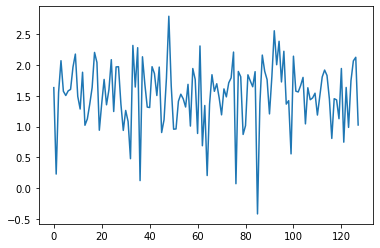

In [73]:
plt.plot(org_fc1[0].detach().numpy())

In [84]:
tmp_fc1 = fullyConnected1(hec, tenc, org_model.fc1)

In [ ]:
hec.pa

In [85]:
dec = hec.decrypt(tmp_fc1)

In [86]:
dec

array([1.63368942, 1.60186548, 1.62132419, ..., 1.60176105, 1.60176362,
       1.60175942])

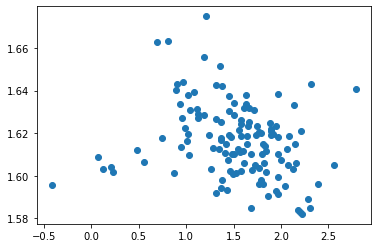

In [88]:
plt.scatter(org_fc1[0].detach().numpy(), dec[:128])
plt.show()